In [3]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import time
import math


In [4]:

def logkernel(sigma,kernel_size):
    #kernel size =5x5 or 9x9 or X x X kernelSize = max(1,fix(6*sigma)+1)
    #use Vectorize to speed up
    #e=2.718
    #9=-4 to 4
    #print("creating LoG kernel")
    center_px=int(((kernel_size-1)/2))
    #print("center",center_px)
    log_kernel=np.empty([kernel_size,kernel_size])
    for i in range(kernel_size):
        for j in range(kernel_size):
            x=i-center_px
            y=j-center_px
            #log_kernel[i][j]=((-1.0)/(3.14*(sigma**4)))*(1-(((p)**2+(q)**2)/2*(sigma**2)))*(2.718** (-1*(p**2+q**2)/(2*(sigma**2))))
            ##log_kernel[i][j]=((x**2)+(y**2)-(2*(sigma**2))) * 2.718**(-1*(x**2+y**2)/(2*(sigma**2)))
            log_kernel[i][j] = ((-1.0)/(math.pi*(sigma**4)))*(1-((x**2+y**2)/(2*sigma**2)))*math.exp(-1*((x**2+y**2)/(2*sigma**2)))

    return log_kernel


In [5]:

def convOp(image, kernel):
    #print("doing convolution")
    #start_con=time.time()
    kernelSize=kernel.shape[0]
    ker_x=kernel.shape[0]//2 
    ker_y=ker_x
    h,w=image.shape
    #s=ker_x
    
    #print(image.shape[0],image.shape[1])
    #create padding for obtaining same size Image
    paddedImage = (np.zeros((h+2*ker_x,w+2*ker_y)))
    paddedImage[ker_x:-ker_x,ker_y:-ker_y]=image
    matrix=np.zeros(image.shape)
    for r in range(ker_x,paddedImage.shape[0]-ker_x):
        for c in range(ker_y,paddedImage.shape[1]-ker_x):
            ###Big Time consumer: np.sum(img_array) is 30 sec more delayed than .sum()###
            matrix[r-ker_x,c-ker_y]=(paddedImage[r-ker_x:r+ker_x+1,c-ker_x:c+ker_x+1]*kernel).sum()
    #print('Time to Convolve: %0.8f'%(time.time()-start_con))
    return   matrix**2



In [6]:
def newScaleSpace(image,sigma,k,scale_space):
    output = np.zeros((image.shape[0],image.shape[1],scale_space))
    sigma_init=sigma
    
    for i in range(scale_space):
        sigma_new=sigma_init*(k**i)
        #print(sigma_new)
        filter_size=(int(6*sigma_new))
        if(filter_size%2==0):
            filter_size=filter_size+1
        kernel=logkernel(sigma_new,filter_size)
        kernel_normalized=np.array(kernel)*(sigma_new**2)
        img_im=convOp(image,kernel_normalized) #kernel
        #cv2.imshow(str(i),img_im)
        output[:,:,i]=img_im ###
    return output



In [7]:
def blobDetection(output,gray_image):
    print("drawingblob")
    rad = sigma_value*math.sqrt(2)
    #data = 0
    for count in range(output.shape[2]):
        for i in range(gray_image.shape[0]):
            for j in range(gray_image.shape[1]):
                radius = rad*(k**(count+1))
                if(output[i][j][count]==1):
                    #data = data+1
                    output_img = cv2.circle(gray_image,(j,i),int(radius),(0,0,255))
    plt.imshow(output_img)
    #plt.imsave("BlobImage_eins3"+"_"+".jpg",arr=output_img)
    return output_img

In [8]:

def nonMaximumSuppression(conv_output,threshold):
    print("doing nonMax")
    max_detected_px=0
    non_max_layers=np.zeros((conv_output.shape[0],conv_output.shape[1],conv_output.shape[2]-2))
    for layer in range(conv_output.shape[2]-2):
        for i in range(1,conv_output.shape[0]):
            for j in range(1, conv_output.shape[1]):
                if(layer+1<1):
                    maxValue = np.amax(np.array(conv_output[i-1:i+2,j-1:j+2,layer+1:layer+1+2]))
                elif(layer+1>scale_space-1):
                    maxValue = np.amax(np.array(conv_output[i-1:i+2,j-1:j+2,layer+1-1:layer+1+1]))
                else:
                    maxValue = np.amax(np.array(conv_output[i-1:i+2,j-1:j+2,layer+1-1:layer+1+2]))
                if(maxValue==0):
                    non_max_layers[i][j][layer]=1
                else:
                    if((maxValue == conv_output[i][j][layer+1]) and (maxValue>threshold)):
                        non_max_layers[i][j][layer]=1
                    else:
                        non_max_layers[i][j][layer]=0
                if(non_max_layers[i][j][layer]==1):
                    max_detected_px = max_detected_px+1
    #print(max_detected_px)
    return non_max_layers

In [9]:

def downSampling(sigma,scale_space,k,image):
    output = np.zeros((image.shape[0],image.shape[1],scale_space))
    downsampledImage = image
    kernelSize = int(6*sigma)
    if(kernelSize%2==0):
        kernelSize = kernelSize+1
    kernel = logkernel(sigma,kernelSize)
    kernel_normalized = np.array(kernel)*(sigma**2)
    for i in range(scale_space):
        new_scalefactor = (1/k)**(i)
        downsampledImage = cv2.resize(image,(math.ceil(image.shape[1]*new_scalefactor),math.ceil(image.shape[0]*new_scalefactor)))
        imgStorageList = np.empty((downsampledImage.shape[0],downsampledImage.shape[1]))
        imgStorageList[:,:] = convOp(downsampledImage,kernel_normalized)
        output[:,:,i] = cv2.resize(imgStorageList,(int(image.shape[1]),int(image.shape[0])))
    blobImage = nonMaximumSuppression(output,0.01)
    return blobImage 


Enter name of the image: fishes.jpg
Enter the location of the image using (/)forward slashes only :fishes.jpg
choose 1 for increasing scale-factor (or) 2 for downsampling method :2
doing nonMax
drawingblob
total time 27.4201


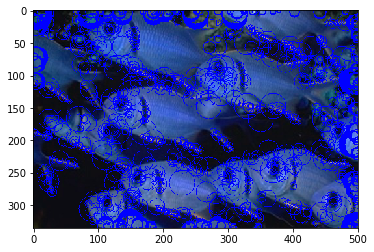

In [10]:
if __name__=='__main__':
    sigma_value=0.707
    k=1.24
    scale_space=16
    threshold=0.01
    ImageName=input("Enter name of the image: ")
    ImgAddress=input("Enter the location of the image using (/)forward slashes only :")
    implementationMethod= int(input("choose 1 for increasing scale-factor (or) 2 for downsampling method :"))
    
    InputImage=cv2.imread(ImgAddress,0)
    img_arr = np.array(InputImage,dtype=int)/255
    colored_img= cv2.imread(ImgAddress)
    #timing the entire process
    start_time=time.time()
    if implementationMethod==1:
        #increasing the scale
        tag="incScale"
        output_convolved = newScaleSpace(img_arr,sigma_value,k,scale_space)
        imageMaximums = nonMaximumSuppression(output_convolved,threshold)
        image_with_blobs = blobDetection(imageMaximums,colored_img)
    elif implementationMethod==2:
        #downsampling method  
        tag="downSampled"
        ImgAfterOp = downSampling(sigma_value,scale_space,k,img_arr)
        image_with_blobs=blobDetection(ImgAfterOp,colored_img)
    
    cv2.imwrite('Blobs_on_'+ImageName+'_'+tag+'.jpg',image_with_blobs)
    print ("total time %0.4f"%(time.time()-start_time))
        